# Inferencing Stable Diffusion

### Created for VLILAB member

In [99]:
# in the google colab, set the hardware accelerator to GPU, by following these steps:
# (in the menu bar) Runtime -> change runtime type -> Hardware accelerator -> GPU

import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [100]:
# install these dependencies
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

In [101]:
# Load the text encoder, UNet, scheduler, and VAE

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler

# 1. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 2. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# 3. Load the K-LMS scheduler for scheduling the denoising step (in UNet)
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# 4. Load the autoencoder (VAE) model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.8.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'l

In [102]:
# move the model to the GPU (for speeding up the process)
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [103]:
# Input the prompt and other parameters
prompt = ["an astronaut is playing guitar on the moon"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [104]:
# Get the text embeddings for the prompt.
# These embeddings will be used to condition the UNet model.
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [105]:
# Get the unconditional text embeddings for classifier-free guidance.
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

In [106]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [107]:
# Generate the initial random noise (latent seed)
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
print(latents.shape)

torch.Size([1, 4, 64, 64])


In [108]:
# initialize the scheduler with our chosen num_inference_steps (N)
scheduler.set_timesteps(num_inference_steps)

In [109]:
latents = latents * scheduler.init_noise_sigma

In [110]:
# Denoising step (loop for N times)
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [111]:
# scale and decode the image latents with vae.
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

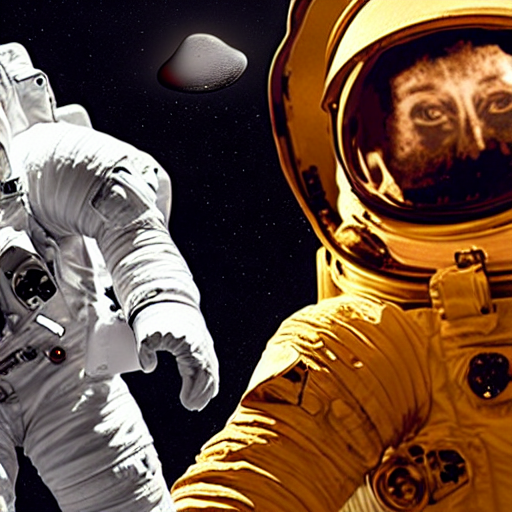

In [112]:
# Convert the image to PIL for displaying or saving it.
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]